# Support Vector Machine Video Classifier

This notebook uses Support Vector Machine to predict a Youtube category based off of 
the title. We will run this on three inputs. Filtered titles, filtered and normalized titles, and
filtered titles with no stop words

## Overview

**Numeric input variables with n dimensions form an n-dimensional space. For example, a data set containing 2 input numeric variables (e.g. height and weight) forms a 2-dimension space.**

<img src="svm.png">

To give a little background information on **support vector machines**, there are some key concepts to mention:

- **Hyperplane**: a hyperplane is an n-1 dimensional object that splits the input variable n-dimensional space. In the above graph, it is simply the red lines.
  
- **Margin**: the distance between the hyperplane and the closest data points, or the perpendicular distance from the hyperplane to only the closest data points.
  
- **Maximal-Margin Classifier**: a classification model that learns and separates data points using a hyperplane that maximizes the margin.
  
- **Support Vectors**: data points that support and define the hyperplane, usually ones closest to the hyperplane.

<img src="svm_def.png">

<img src="linear_svm.png">
<div align='right'> source: https://machinelearningmastery.com/support-vector-machines-for-machine-learning/ <div/>

## Setup

In [32]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix
from yellowbrick.text import FreqDistVisualizer
from sklearn.metrics import roc_curve, auc

### Load data and get Data

Here, we want to load the csv file and separate each column. 

In [2]:
df_titles_info = pd.read_csv('./output/US_count_vectorizer_dataset.csv')
df_titles_info.head()

,title,filter_title,filter_title_no_stops,category_id
0,WE WANT TO TALK ABOUT OUR MARRIAGE,we want to talk about our marriage,want talk marriage,People & Blogs
1,The Trump Presidency: Last Week Tonight with J...,the trump presidency last week tonight with jo...,trump presidency last week tonight john oliver...,Entertainment
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",racist superman rudy mancuso king bach lele pons,racist superman rudy mancuso king bach lele pons,Comedy
3,Nickelback Lyrics: Real or Fake?,nickelback lyrics real or fake,nickelback lyrics real fake,Entertainment
4,I Dare You: GOING BALD!?,i dare you going bald,dare going bald,Entertainment


### Feature Selection

1. df_x are regular, filtered titles
2. df_x2 are filtered titles that does not contain stop words
3. df_y are video categories
4. target_names are all the possible categories

In [3]:
df_x = df_titles_info['filter_title']
df_x2 = df_titles_info['filter_title_no_stops']
df_y = df_titles_info['category_id']
target_names = list(df_titles_info['category_id'].unique())

### Split the data

We want to split the data here where 80 percent are reserved for training and 20 percent is reserved for testing

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_x2, df_y, test_size=0.2)

Make sure training and testing data don't contain null values before tokenizing

In [5]:
# replace NaN with spaces so count vectorizer can work
x_train2 = x_train2.fillna('')
x_test2 = x_test2.fillna('')

In [6]:
if x_train.isna().sum() != 0:
    print("x_train has null values")
elif x_test.isna().sum() != 0:
    print("x_test has null values")
elif y_train.isna().sum() != 0:
    print("y_train has null values")
elif y_test.isna().sum() != 0:
    print("y_test has null values")
elif x_train2.isna().sum() != 0:
    print("x_train2 has null values")
elif x_test2.isna().sum() != 0:
    print("x_test2 has null values")
elif y_train2.isna().sum() != 0:
    print("y_train2 has null values")
elif y_test2.isna().sum() != 0:
    print("y_test2 has null values")
else:
    print("Good to go!")

Good to go!


### Tokenize training video titles using CountVectorizer

Here, we want to convert our video titles into a frequency matrix of individual vocabularies
so the SVM model can recognize it. CountVectorizer applies the Bag of Words method (BoW) without considering the uniqueness of words across all video titles

In [7]:
count_vectorizer = CountVectorizer()
train_count_vector = count_vectorizer.fit_transform(x_train)
test_count_vector = count_vectorizer.transform(x_test)

Now we have converted individual video titles into frequency vectors that indicate whether that title contains the vocabularies specified at a particular index. There is a total of 32759 titles, each converted into a frequency vector of size 10545

In [8]:
print(train_count_vector.shape)
print(train_count_vector.toarray())

(32759, 10545)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


___

Now we have converted individual video titles filtered with stopwords into frequency vectors that indicate whether that title contains the vocabularies specified at a particular index. There is a total of 32759 titles, each converted into a frequency vector of size 10545

In [9]:
count_vectorizer_2 = CountVectorizer()
train_count_vector_2 = count_vectorizer_2.fit_transform(x_train2)
test_count_vector_2 = count_vectorizer_2.transform(x_test2)

In [10]:
print(train_count_vector_2.toarray())
print(train_count_vector_2.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(32759, 10526)


### Normalize title frequencies using TF-IDF

Now we apply the TF-IDF method to the video titles to assign extra weights to words that are more unique in a particular title and less weight to words that appear more often across all titles. There is a total of 32759 titles, each converted into a frequency vector of size 10545. This can potentially improve prediction accuracy

In [11]:
tfidf_transformer = TfidfTransformer()
x_trained_tfidf_vector = tfidf_transformer.fit_transform(train_count_vector)
x_test_tfidf_vector = tfidf_transformer.transform(test_count_vector)

In [12]:
print(x_trained_tfidf_vector.shape)
print(x_trained_tfidf_vector.toarray())

(32759, 10545)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


---

In [13]:
tfidf_transformer_2 = TfidfTransformer()
x_trained_tfidf_vector_2 = tfidf_transformer_2.fit_transform(train_count_vector_2)
x_test_tfidf_vector_2 = tfidf_transformer_2.transform(test_count_vector_2)

In [14]:
print(x_trained_tfidf_vector_2.shape)
print(x_trained_tfidf_vector_2.toarray())

(32759, 10526)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Train SVM Model and assess prediction accuracy using different input

1. Here we want to use our previously split training data to train the SVM model.
2. Afterwards, we will feed it our testing test and print out an accuracy report.

<img src="precision_recall.png">

### Using titles with stop words

Accuracy:  0.9866910866910867
                       precision    recall  f1-score   support

       People & Blogs       1.00      0.99      0.99        72
        Entertainment       0.97      0.98      0.97       690
               Comedy       1.00      0.98      0.99       368
 Science & Technology       0.98      0.99      0.98      2039
     Film & Animation       0.99      0.99      0.99       465
      News & Politics       1.00      1.00      1.00       155
               Sports       1.00      0.98      0.99       789
                Music       0.99      1.00      0.99      1273
       Pets & Animals       0.99      0.98      0.99       482
            Education       1.00      0.92      0.96        13
        Howto & Style       0.98      0.98      0.98       634
     Autos & Vehicles       0.98      0.99      0.99       174
      Travel & Events       0.99      0.99      0.99       499
               Gaming       1.00      1.00      1.00        11
Nonprofits & Activism   

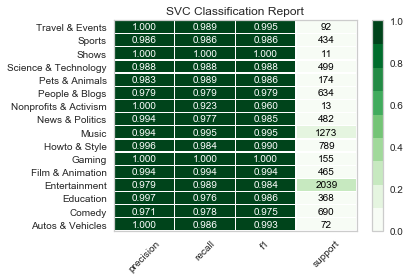

In [15]:
svm_count = SVC(kernel='linear').fit(train_count_vector, y_train)
svm_pred_count = svm_count.predict(test_count_vector)

count_accuracy_stop = accuracy_score(y_test, svm_pred_count)
print("Accuracy: ", count_accuracy_stop)
print(metrics.classification_report(y_test, svm_pred_count, target_names=target_names))

visualizer = ClassificationReport(svm_count, support=True, cmap='Greens')
visualizer.fit(train_count_vector, y_train)
visualizer.score(test_count_vector, y_test)
visualizer.show()

Overall, the prediction accuracy is quite high. It seems the model is the most confused about videos in the Nonprofits & Activism category. This makes sense because there are too few videos in that category for the model to learn.

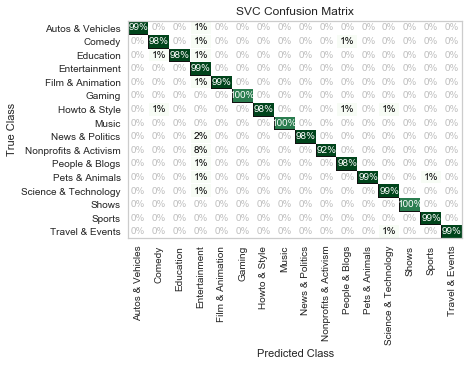

In [16]:
conf_matrix = ConfusionMatrix(svm_count, percent=True, cmap='Greens')
conf_matrix.fit(train_count_vector, y_train)
conf_matrix.score(test_count_vector, y_test)
conf_matrix.show()

Accuracy:  0.9819291819291819
                       precision    recall  f1-score   support

       People & Blogs       0.97      0.96      0.97        72
        Entertainment       0.98      0.96      0.97       690
               Comedy       1.00      0.97      0.99       368
 Science & Technology       0.96      0.99      0.98      2039
     Film & Animation       1.00      0.98      0.99       465
      News & Politics       1.00      0.98      0.99       155
               Sports       0.99      0.98      0.99       789
                Music       0.99      0.99      0.99      1273
       Pets & Animals       0.98      0.97      0.98       482
            Education       1.00      0.92      0.96        13
        Howto & Style       0.98      0.97      0.97       634
     Autos & Vehicles       0.98      0.99      0.99       174
      Travel & Events       0.99      0.98      0.98       499
               Gaming       1.00      1.00      1.00        11
Nonprofits & Activism   

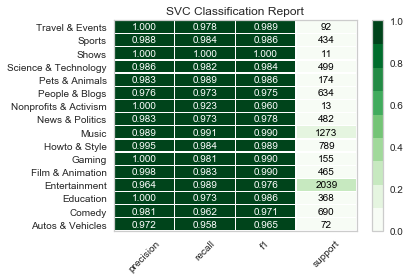

In [17]:
svm_tfidf = SVC(kernel='linear').fit(x_trained_tfidf_vector, y_train)
svm_pred_tfidf = svm_tfidf.predict(x_test_tfidf_vector)

tfidf_accuracy_stop = accuracy_score(y_test, svm_pred_tfidf)
print("Accuracy: ", tfidf_accuracy_stop)
print(metrics.classification_report(y_test, svm_pred_tfidf, target_names=target_names))

visualizer = ClassificationReport(svm_tfidf, support=True, cmap='Greens')
visualizer.fit(x_trained_tfidf_vector, y_train)
visualizer.score(x_test_tfidf_vector, y_test)
visualizer.show()

Overall, the prediction accuracy is quite high. It seems the model is the most confused about videos in the Nonprofits & Activism category. This makes sense because there are too few videos in that category for the model to learn. Additionally, the model is preferentially characterizing videos of all categories into the Entertainment category. This makes sense because Entertainment is a rather broad category encompassing many other categories. Further fine-tuning is needed to resolve this issue.

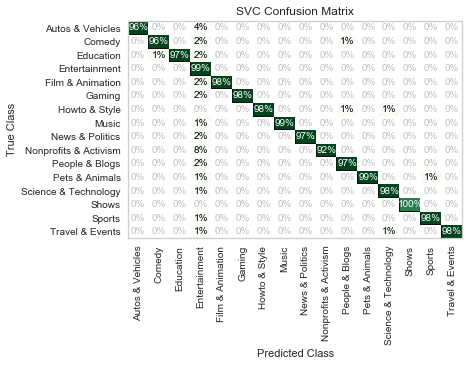

In [18]:
conf_matrix = ConfusionMatrix(svm_tfidf, percent=True, cmap='Greens')
conf_matrix.fit(x_trained_tfidf_vector, y_train)
conf_matrix.score(x_test_tfidf_vector, y_test)
conf_matrix.show()

### Using titles without stop words

Accuracy:  0.9866910866910867
                       precision    recall  f1-score   support

       People & Blogs       1.00      1.00      1.00        67
        Entertainment       0.98      0.98      0.98       725
               Comedy       0.99      0.99      0.99       342
 Science & Technology       0.98      0.99      0.98      2029
     Film & Animation       0.99      0.99      0.99       476
      News & Politics       0.99      0.99      0.99       172
               Sports       0.99      0.99      0.99       799
                Music       0.99      0.99      0.99      1295
       Pets & Animals       0.99      0.97      0.98       514
            Education       1.00      1.00      1.00         6
        Howto & Style       0.97      0.98      0.98       590
     Autos & Vehicles       0.99      0.99      0.99       172
      Travel & Events       1.00      0.98      0.99       467
               Gaming       1.00      1.00      1.00         8
Nonprofits & Activism   

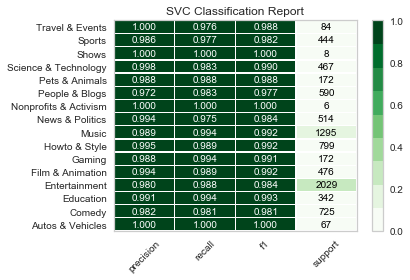

In [19]:
svm_count_2 = SVC(kernel='linear').fit(train_count_vector_2, y_train2)
svm_pred_count_2 = svm_count_2.predict(test_count_vector_2)

count_accuracy_non_stop = accuracy_score(y_test2, svm_pred_count_2)
print("Accuracy: ", count_accuracy_non_stop)
print(metrics.classification_report(y_test2, svm_pred_count_2, target_names=target_names))

visualizer = ClassificationReport(svm_count_2, support=True, cmap='Greens')
visualizer.fit(train_count_vector_2, y_train2)
visualizer.score(test_count_vector_2, y_test2)
visualizer.show()

Overall, the prediction accuracy is quite high. It seems the model is the most confused about videos in the Nonprofits & Activism category. This makes sense because there are too few videos in that category for the model to learn. Additionally, the model is preferentially characterizing videos of all categories into the Entertainment category. This makes sense because Entertainment is a rather broad category encompassing many other categories. Further fine-tuning is needed to resolve this issue.

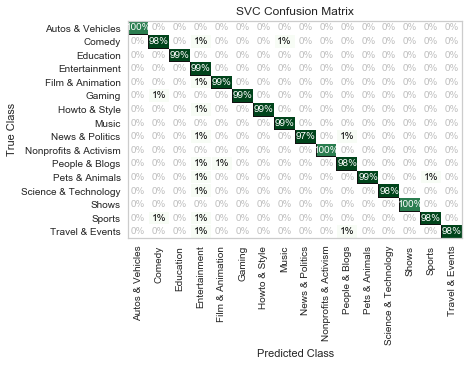

In [20]:
conf_matrix = ConfusionMatrix(svm_count_2, percent=True, cmap='Greens')
conf_matrix.fit(train_count_vector_2, y_train2)
conf_matrix.score(test_count_vector_2, y_test2)
conf_matrix.show()

Accuracy:  0.9816849816849816
                       precision    recall  f1-score   support

       People & Blogs       1.00      1.00      1.00        67
        Entertainment       0.98      0.97      0.97       725
               Comedy       0.99      0.99      0.99       342
 Science & Technology       0.96      0.99      0.98      2029
     Film & Animation       0.99      0.99      0.99       476
      News & Politics       1.00      0.97      0.99       172
               Sports       0.99      0.99      0.99       799
                Music       0.99      0.99      0.99      1295
       Pets & Animals       0.99      0.97      0.98       514
            Education       1.00      1.00      1.00         6
        Howto & Style       0.97      0.96      0.97       590
     Autos & Vehicles       0.99      0.98      0.98       172
      Travel & Events       0.99      0.98      0.99       467
               Gaming       1.00      1.00      1.00         8
Nonprofits & Activism   

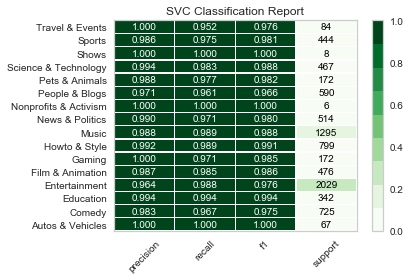

In [21]:
svm_tfidf_2 = SVC(kernel='linear').fit(x_trained_tfidf_vector_2, y_train2)
svm_pred_tfidf_2 = svm_tfidf_2.predict(x_test_tfidf_vector_2)

tfidf_accuracy_non_stop = accuracy_score(y_test2, svm_pred_tfidf_2)
print("Accuracy: ", tfidf_accuracy_non_stop)
print(metrics.classification_report(y_test2, svm_pred_tfidf_2, target_names=target_names))

visualizer = ClassificationReport(svm_tfidf_2, support=True, cmap='Greens')
visualizer.fit(x_trained_tfidf_vector_2, y_train2)
visualizer.score(x_test_tfidf_vector_2, y_test2)
visualizer.show()

Overall, the prediction accuracy is quite high. It seems the model is the most confused about videos in the Nonprofits & Activism category. This makes sense because there are too few videos in that category for the model to learn. Additionally, the model is preferentially characterizing videos of all categories into the Entertainment category. This makes sense because Entertainment is a rather broad category encompassing many other categories. Further fine-tuning is needed to resolve this issue.

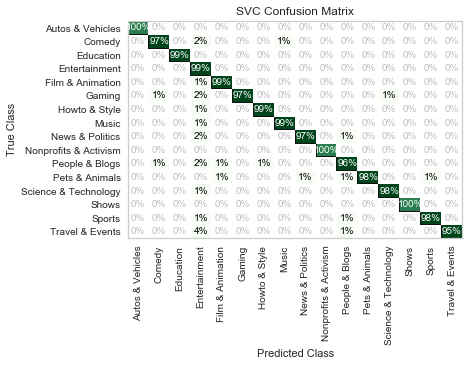

In [22]:
conf_matrix = ConfusionMatrix(svm_tfidf_2, percent=True, cmap='Greens')
conf_matrix.fit(x_trained_tfidf_vector_2, y_train2)
conf_matrix.score(x_test_tfidf_vector_2, y_test2)
conf_matrix.show()

### Repeat multiple runs of re-partitioning to access model accuracy
Optionally run the above code multiple times to assess precision of the models. However, this is very computationally expensive! Proceed with patience!

```python
tf_stop_words = np.array([])
tf_non_stop = np.array([])
tfidf_stop_words = np.array([])
tfidf_non_stop = np.array([])

for i in np.arange(10):
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(df_x2, df_y, test_size=0.2)

    # replace NaN with spaces so count vectorizer can work
    x_train2 = x_train2.fillna('')
    x_test2 = x_test2.fillna('')

    if x_train.isna().sum() != 0:
        print("x_train has null values")
    elif x_test.isna().sum() != 0:
        print("x_test has null values")
    elif y_train.isna().sum() != 0:
        print("y_train has null values")
    elif y_test.isna().sum() != 0:
        print("y_test has null values")
    elif x_train2.isna().sum() != 0:
        print("x_train2 has null values")
    elif x_test2.isna().sum() != 0:
        print("x_test2 has null values")
    elif y_train2.isna().sum() != 0:
        print("y_train2 has null values")
    elif y_test2.isna().sum() != 0:
        print("y_test2 has null values")
    else:
        print("Good to go!")
    
    count_vectorizer = CountVectorizer()
    train_count_vector = count_vectorizer.fit_transform(x_train)
    test_count_vector = count_vectorizer.transform(x_test)

    count_vectorizer_2 = CountVectorizer()
    train_count_vector_2 = count_vectorizer_2.fit_transform(x_train2)
    test_count_vector_2 = count_vectorizer_2.transform(x_test2)
    
    tfidf_transformer = TfidfTransformer()
    x_trained_tfidf_vector = tfidf_transformer.fit_transform(train_count_vector)
    x_test_tfidf_vector = tfidf_transformer.transform(test_count_vector)
    
    tfidf_transformer_2 = TfidfTransformer()
    x_trained_tfidf_vector_2 = tfidf_transformer_2.fit_transform(train_count_vector_2)
    x_test_tfidf_vector_2 = tfidf_transformer_2.transform(test_count_vector_2)
    
    svm_count = SVC(kernel='linear').fit(train_count_vector, y_train)
    svm_pred_count = svm_count.predict(test_count_vector)
    tf_stop_words = np.append(tf_stop_words, accuracy_score(y_test, svm_pred_count))
    
    svm_tfidf = SVC(kernel='linear').fit(x_trained_tfidf_vector, y_train)
    svm_pred_tfidf = svm_tfidf.predict(x_test_tfidf_vector)
    tfidf_stop_words = np.append(tfidf_stop_words, accuracy_score(y_test, svm_pred_tfidf))
    
    svm_count_2 = SVC(kernel='linear').fit(train_count_vector_2, y_train2)
    svm_pred_count_2 = svm_count_2.predict(test_count_vector_2)
    tf_non_stop = np.append(tf_non_stop, accuracy_score(y_test2, svm_pred_count_2))
    
    svm_tfidf_2 = SVC(kernel='linear').fit(x_trained_tfidf_vector_2, y_train2)
    svm_pred_tfidf_2 = svm_tfidf_2.predict(x_test_tfidf_vector_2)
    tfidf_non_stop = np.append(tfidf_non_stop, accuracy_score(y_test2, svm_pred_tfidf_2))
    
pd.DataFrame(tf_stop_words=tf_stop_words, tfidf_stop_words=tfidf_stop_words, tf_non_stop=tf_non_stop, tfidf_non_stop=tfidf_non_stop).boxplot(column=['tf_stop_words','tfidf_stop_words','tf_non_stop','tfidf_non_stop'])
```

In [23]:
result = pd.DataFrame().assign(Regular_Filter=[count_accuracy_stop],Regular_No_Stopwords=[count_accuracy_non_stop], Filtered_Normalized=[tfidf_accuracy_stop]).transpose()

In [24]:
result.columns = ['Accuracy Score']

Text(0.5, 1.0, 'SVM Prediction Accuracy based on Input Type')

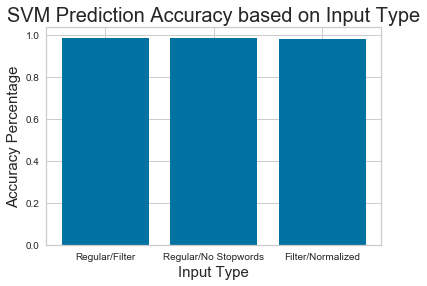

In [25]:
y=[count_accuracy_stop, count_accuracy_non_stop, tfidf_accuracy_stop]
x=["Regular/Filter", "Regular/No Stopwords", "Filter/Normalized"]

plt.bar(x, y) 
plt.xlabel("Input Type", fontsize=15)
plt.ylabel("Accuracy Percentage", fontsize=15)
plt.xticks(rotation=0)
plt.title("SVM Prediction Accuracy based on Input Type", fontsize=20)

#for index, value in enumerate(y):
 #    plt.text(value, index, str(value), color='blue', fontweight='bold')

In [26]:
print(y)

[0.9866910866910867, 0.9866910866910867, 0.9819291819291819]


## Analysis

Using linear SVM, the prediction accuracy of video category based on title is consistently high across all groups of given input, with little difference among the various groups. Interestingly, inputting the raw count matrix yields a slightly higher accuracy than inputting weighted score matrix with TF-IDF, implying the uniqueness of words in a title might not be important in predicting categories. Additionally, removing stop words from video titles slightly enhances the accuracy of the linear SVM model. This is expected because there is less noise with stopwords removed. The above code can be run multiple times to further access the precision of the model between runs. More investigation is required to identify sources for misclassification in the various categories.

<img src="bias_variance_tradeoff.png">
<div align='right'>source: https://elitedatascience.com/overfitting-in-machine-learning <div/>

To further investigate whether the high accuracy scores result from model overfitting, K-fold cross-validation can be performed to measure the average accuracy scores of k different partitions of the original dataset to ensure no overfittiing. 